# Hybrid Switching  
  
The Hybrid Switching solver is designed to allow a model's species to be represented dynamically as either continuous or stochastic throughout the simulation.  This solver will represent a reaction channel deterministically at high populations in order to favor performance, and will automatically switch to a stochastic representation at lower populations.  This allows for substantial run-time improvements over the SSA, minimizing the loss of stochastic accuracy.  
  
There is no special setup for the standard case of using this switching mechanism, however for cases where a particular species should always be represented as 'stochastic' or always represented as 'continuous,' the GillesPy2.species can be constructed with kwarg 'mode' locking that into place.  
  
  
**mode='dynamic'(default) - allows for hybrid switching  
mode='continuous' - forces a species to be modeled continuously/deterministically  
mode='discrete' - forces a species to be modeled discretely/stochastically**  
  
Ex:  
A = GillesPy2.Species(name='A', initial_value=400, mode='continuous')

In [1]:
import sys, os
import numpy
import matplotlib.pyplot as plt
plt.style.use('dark_background')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
sys.path.append('../../../')

In [2]:
import gillespy2
from gillespy2.solvers.numpy.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.solvers.numpy.ssa_solver import NumPySSASolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [3]:
class AutomaticSwitchExample(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Automatic Switch Example")
            
            #parameters
            k1 = gillespy2.Parameter(name='k1', expression= 3e-4)
            k2 = gillespy2.Parameter(name='k2', expression= .5e-2)
            k3 = gillespy2.Parameter(name='k3', expression = 2e-1)
            self.add_parameter([k1,k2,k3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=400)
            B = gillespy2.Species(name='B', initial_value=10000)
            C = gillespy2.Species(name='C', initial_value=10000)
            self.add_species([A, B, C])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={B:1,C:1},
                   rate=k1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={B:1}, products={},
                    rate=k2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={A:1},
                    rate=k3)

            self.add_reaction([r1,r2,r3])
            self.timespan(numpy.linspace(0,600,601))

In [4]:
model = AutomaticSwitchExample()
results = {}

In [5]:
# %time tau_hybrid_results = model.run(solver=BasicTauHybridSolver)

In [6]:
# plt.figure(figsize=(15, 10))
# for species in tau_hybrid_results[0]:
#     if species == 'time': continue
#     plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='{0}'.format(species))
# plt.title('Example Hybrid Switching Model')
# plt.legend(loc='best')

The hybrid switching condition is based on a coefficient of variance for each species.  The error threshhold for this condition can be user modified by instantiating the solver, and calling the run function from it, rather than the solver.  
  
The default value is .003 and is a threshold to the coefficient of variance for each species at the selected forward step (t + tau).  Because of this relationship to the selected tau, this value may need to be adjusted when adjusting the tau_tol during a simulation (larger tau_tol / tau steps will result in greater variance, and subsequently requires a higher switch tolerance).

In [7]:
# %time results2 = model.run(solver=BasicTauHybridSolver, switch_tol=1)

In [8]:
# plt.figure(figsize=(15, 10))
# for species in results2[0]:
#     if species == 'time': continue
#     plt.plot(results2[0]['time'], results2[0][species], label='{0}'.format(species))
# plt.title('Example Hybrid Switching Model')
# plt.legend(loc='best')

In [9]:
# plt.figure(figsize=(15, 10))
# plt.title('Comparison of Hybrid Switching Results default vs higher tolerance')
# for species in results2[0]:
#     if species == 'time': continue
#     plt.plot(results2[0]['time'], results2[0][species], label='High tol-{0}'.format(species))
# for species in tau_hybrid_results[0]:
#     if species == 'time': continue
#     plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Default tol-{0}'.format(species))
#     plt.legend(loc='best')

Additionally, both the hybrid_tol and tau_tol can be modified to result in extremely fast simulations.

In [13]:
# for name, spec in model.listOfSpecies.items():
#     spec.mode = 'discrete'
%time results3 = model.run(solver=BasicTauHybridSolver, switch_tol=.03, tau_tol=0.5, debug=True)

t =  600.0
increment =  1.0
dependencies
OrderedDict([('r1', {'C', 'B', 'A'}), ('r2', {'B'}), ('r3', {'C', 'A'})])
Setting Random number  -0.8182735327315906  for  r1
Setting Random number  -0.9863811460422602  for  r2
Setting Random number  -0.7002727466161242  for  r3
Calculating mean, standard deviation at time 0.08333333333333333
mean: {'A': 466.66666666666663, 'B': 9995.833333333334, 'C': 9933.333333333334}
standard deviation: OrderedDict([('A', 21.602468994692867), ('B', 99.97916449607555), ('C', 99.66610925150702)])
CV: OrderedDict([('A', 0.04629100498862757), ('B', 0.010002083984601139), ('C', 0.010033500931359766)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
diffeq for  B
0 + -1*(k2*B)
creating rate rules for  frozenset({'r2'})
OrderedDict([('B', <code object <module> at 0x7fdc5f4a6d20, file "<string>", line 1>)])
Curr Time:  0  Save time:  1.0 step:  0.08333333333333333
step size:  0.08333333333333333
OrderedDict([('r1', 108),

rxn offset =  OrderedDict([('r1', -2.139848241101584), ('r2', -0.9863811460422602), ('r3', -1.0150900279511386)])
Calculating mean, standard deviation at time 6.085871211162619
mean: {'A': 670.3382026802243, 'B': 9700.288668838075, 'C': 9729.661797319775}
standard deviation: OrderedDict([('A', 25.890890341589728), ('B', 98.49004350104671), ('C', 98.63904803534844)])
CV: OrderedDict([('A', 0.0386236234755378), ('B', 0.010153310572853715), ('C', 0.010137972941929028)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  6.0  Save time:  7.0 step:  0.08587121116261913
step size:  0.08587121116261913
OrderedDict([('r1', 166), ('r3', 175)])
Reactions Fired:  OrderedDict([('r1', 166), ('r3', 175)])
y(t) =  [ 9.70028956e+03 -2.14030469e+00 -1.35662625e-01]
rxn offset =  OrderedDict([('r1', -2.1403046922100035), ('r2', -0.9863811460422602), ('r3', -0.1356626247261712)])
Calculating mean, standard deviation at time 6.171779299565932
mean: {'A

rxn offset =  OrderedDict([('r1', -4.646499823155908), ('r2', -0.9863811460422602), ('r3', -1.2175439133563932)])
Calculating mean, standard deviation at time 10.789837920185725
mean: {'A': 691.1585177543329, 'B': 9474.801555683283, 'C': 9708.841482245667}
standard deviation: OrderedDict([('A', 26.289893833074583), ('B', 97.338592324336), ('C', 98.53345361980197)])
CV: OrderedDict([('A', 0.03803743013758115), ('B', 0.010273417522496739), ('C', 0.010148837407633837)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  10.701923991814443  Save time:  11.0 step:  0.08791392837128219
step size:  0.08791392837128219
OrderedDict([('r1', 147), ('r3', 155)])
Reactions Fired:  OrderedDict([('r1', 147), ('r3', 155)])
y(t) =  [ 9.47480247e+03 -2.24989688e+00 -4.42245333e-01]
rxn offset =  OrderedDict([('r1', -2.249896883368796), ('r2', -0.9863811460422602), ('r3', -0.44224533290376966)])
Calculating mean, standard deviation at time 10.87779050

Curr Time:  15.539548059374479  Save time:  16.0 step:  0.09006632735259208
step size:  0.09006632735259208
OrderedDict([('r1', 187), ('r3', 164)])
Reactions Fired:  OrderedDict([('r1', 187), ('r3', 164)])
y(t) =  [ 9.24827475e+03 -5.56989806e-01 -1.47423014e-01]
rxn offset =  OrderedDict([('r1', -0.5569898062905108), ('r2', -0.9863811460422602), ('r3', -0.14742301364056554)])
Calculating mean, standard deviation at time 15.719721282930308
mean: {'A': 687.3637420813724, 'B': 9244.108087506802, 'C': 9712.636257918628}
standard deviation: OrderedDict([('A', 26.217622738939784), ('B', 96.146284834656), ('C', 98.55270801920477)])
CV: OrderedDict([('A', 0.03814228353033503), ('B', 0.010400817896601132), ('C', 0.010146854613118617)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  15.62961438672707  Save time:  16.0 step:  0.09010689620323782
step size:  0.09010689620323782
OrderedDict([('r1', 183), ('r3', 164)])
Reactions Fired:  Orde

step size:  0.09239533637766478
OrderedDict([('r1', 167), ('r3', 174)])
Reactions Fired:  OrderedDict([('r1', 167), ('r3', 174)])
y(t) =  [ 9.01504853e+03 -1.06040913e+00 -4.40922973e-01]
rxn offset =  OrderedDict([('r1', -1.0604091331579564), ('r2', -0.9863811460422602), ('r3', -0.44092297343981696)])
Calculating mean, standard deviation at time 20.830408583953254
mean: {'A': 722.6175894620172, 'B': 9010.881866440652, 'C': 9677.382410537983}
standard deviation: OrderedDict([('A', 26.88154737849027), ('B', 94.92566495126938), ('C', 98.37368759245524)])
CV: OrderedDict([('A', 0.03720023947729166), ('B', 0.01053455880992096), ('C', 0.010165319858119203)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  20.73797055322353  Save time:  21.0 step:  0.09243803072972466
step size:  0.09243803072972466
OrderedDict([('r1', 197), ('r3', 168)])
Reactions Fired:  OrderedDict([('r1', 197), ('r3', 168)])
y(t) =  [ 9.01088283e+03 -3.64185803e-01

Calculating mean, standard deviation at time 25.377983888075278
mean: {'A': 735.5023541707302, 'B': 8808.305311097543, 'C': 9664.49764582927}
standard deviation: OrderedDict([('A', 27.120146647293968), ('B', 93.85257221353895), ('C', 98.30817690217467)])
CV: OrderedDict([('A', 0.0368729569572508), ('B', 0.010655008982862405), ('C', 0.010172093832999145)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  25.283420939627213  Save time:  26.0 step:  0.09456294844806488
step size:  0.09456294844806488
OrderedDict([('r1', 170), ('r3', 184)])
Reactions Fired:  OrderedDict([('r1', 170), ('r3', 184)])
y(t) =  [ 8.80830630e+03 -5.59436165e-01 -7.11545468e-02]
rxn offset =  OrderedDict([('r1', -0.5594361654577447), ('r2', -0.9863811460422602), ('r3', -0.0711545468347062)])
Calculating mean, standard deviation at time 25.472591557851057
mean: {'A': 745.8238811332988, 'B': 8804.139629306363, 'C': 9654.1761188667}
standard deviation: OrderedDi

mean: {'A': 768.9269464939522, 'B': 8543.322498276457, 'C': 9631.073053506048}
standard deviation: OrderedDict([('A', 27.729532028037404), ('B', 92.43009519781128), ('C', 98.13803061762574)])
CV: OrderedDict([('A', 0.036062635279560336), ('B', 0.01081898701780932), ('C', 0.010189729646158177)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  31.3895036208568  Save time:  32.0 step:  0.09749451765919595
step size:  0.09749451765919595
OrderedDict([('r1', 181), ('r3', 193)])
Reactions Fired:  OrderedDict([('r1', 181), ('r3', 193)])
y(t) =  [ 8.54332351e+03 -4.55561345e-01 -5.76682452e-01]
rxn offset =  OrderedDict([('r1', -0.45556134520551517), ('r2', -0.9863811460422602), ('r3', -0.5766824518896807)])
Calculating mean, standard deviation at time 31.584540193665728
mean: {'A': 777.7843552308756, 'B': 8539.156847012851, 'C': 9622.215644769125}
standard deviation: OrderedDict([('A', 27.888785474288326), ('B', 92.40755838681623), ('C'

y(t) =  [ 8.31937711e+03 -1.56541366e+00 -1.75256566e+00]
rxn offset =  OrderedDict([('r1', -1.5654136560936234), ('r2', -0.9863811460422602), ('r3', -1.7525656632712514)])
Calculating mean, standard deviation at time 36.899709314941184
mean: {'A': 749.9840368164838, 'B': 8315.210441396295, 'C': 9650.015963183516}
standard deviation: OrderedDict([('A', 27.385836427184103), ('B', 91.18777572348333), ('C', 98.2344947723737)])
CV: OrderedDict([('A', 0.03651522576857891), ('B', 0.010966382193950948), ('C', 0.010179723551458911)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  36.79954155928966  Save time:  37.0 step:  0.10016775565152404
step size:  0.10016775565152404
OrderedDict([('r1', 167), ('r3', 180)])
Reactions Fired:  OrderedDict([('r1', 167), ('r3', 180)])
y(t) =  [ 8.31521148e+03 -3.52833012e-01 -2.24195071e-01]
rxn offset =  OrderedDict([('r1', -0.3528330116237628), ('r2', -0.9863811460422602), ('r3', -0.2241950708476811)

Reactions Fired:  OrderedDict([('r1', 205), ('r3', 210)])
y(t) =  [ 8.08501449e+03 -4.57828662e-01 -1.32760809e+00]
rxn offset =  OrderedDict([('r1', -0.45782866159587343), ('r2', -0.9863811460422602), ('r3', -1.3276080916218864)])
Calculating mean, standard deviation at time 42.617633010865895
mean: {'A': 815.4022437242733, 'B': 8080.847818929833, 'C': 9584.597756275727}
standard deviation: OrderedDict([('A', 28.555248969747634), ('B', 89.89353602417603), ('C', 97.90095891397452)])
CV: OrderedDict([('A', 0.035019831242215145), ('B', 0.01112427037836246), ('C', 0.010214404548158706)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  42.51456166389207  Save time:  43.0 step:  0.10307134697382689
step size:  0.10307134697382689
OrderedDict([('r1', 229), ('r3', 204)])
Reactions Fired:  OrderedDict([('r1', 229), ('r3', 204)])
y(t) =  [ 8.08084889e+03 -8.96334402e-01 -3.55177661e-01]
rxn offset =  OrderedDict([('r1', -0.896334402168119

y(t) =  [ 7.85378192e+03 -8.08931395e-01 -3.71247431e+00]
rxn offset =  OrderedDict([('r1', -0.80893139461602), ('r2', -0.9863811460422602), ('r3', -3.7124743069789656)])
Calculating mean, standard deviation at time 48.424086726214455
mean: {'A': 830.6883230981337, 'B': 7849.6152558468675, 'C': 9569.311676901867}
standard deviation: OrderedDict([('A', 28.821664127841988), ('B', 88.59805446987461), ('C', 97.8228586624919)])
CV: OrderedDict([('A', 0.03469612287355715), ('B', 0.011286929560513356), ('C', 0.010222559570153195)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  48.31798073275104  Save time:  49.0 step:  0.10610599346341823
step size:  0.10610599346341823
OrderedDict([('r1', 210), ('r3', 193)])
Reactions Fired:  OrderedDict([('r1', 210), ('r3', 193)])
y(t) =  [ 7.84961636e+03 -1.71160805e+00 -1.65998805e+00]
rxn offset =  OrderedDict([('r1', -1.7116080482695153), ('r2', -0.9863811460422602), ('r3', -1.6599880522527228)]

det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  53.54368694905151  Save time:  54.0 step:  0.10891492402313667
step size:  0.10891492402313667
OrderedDict([('r1', 220), ('r3', 216)])
Reactions Fired:  OrderedDict([('r1', 220), ('r3', 216)])
y(t) =  [ 7.64706630e+03 -7.52081141e-02 -6.63016977e-01]
rxn offset =  OrderedDict([('r1', -0.07520811410218342), ('r2', -0.9863811460422602), ('r3', -0.6630169767592471)])
Calculating mean, standard deviation at time 53.76157612555408
mean: {'A': 843.4562067872008, 'B': 7642.899629939736, 'C': 9556.543793212799}
standard deviation: OrderedDict([('A', 29.04231751749851), ('B', 87.42367888587013), ('C', 97.75757665374485)])
CV: OrderedDict([('A', 0.03443251384458153), ('B', 0.01143854860312479), ('C', 0.010229386143050351)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  53.65260187307465  Save time:  54.0 step:  0.10897425247943097
ste

Curr Time:  60.33765463055456  Save time:  61.0 step:  0.11267830522865466
step size:  0.11267830522865466
OrderedDict([('r1', 196), ('r3', 213)])
Reactions Fired:  OrderedDict([('r1', 196), ('r3', 213)])
y(t) =  [ 7.39152023e+03 -4.77427647e-01 -1.76429024e+00]
rxn offset =  OrderedDict([('r1', -0.47742764669313775), ('r2', -0.9863811460422602), ('r3', -1.7642902436892345)])
Calculating mean, standard deviation at time 60.563074740900184
mean: {'A': 850.6544928564812, 'B': 7387.353563728385, 'C': 9549.345507143518}
standard deviation: OrderedDict([('A', 29.165981774260253), ('B', 85.9497153208106), ('C', 97.72075269431524)])
CV: OrderedDict([('A', 0.034286519402632505), ('B', 0.011634709856425488), ('C', 0.01023324086673939)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  60.450332935783216  Save time:  61.0 step:  0.11274180511696909
step size:  0.11274180511696909
OrderedDict([('r1', 211), ('r3', 217)])
Reactions Fired:  Ord

mean: {'A': 877.2378576910252, 'B': 7132.55238763067, 'C': 9522.762142308975}
standard deviation: OrderedDict([('A', 29.618201459423986), ('B', 84.45443971533213), ('C', 97.58464091397259)])
CV: OrderedDict([('A', 0.033763022422883066), ('B', 0.011840703737668119), ('C', 0.010247514266938451)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  67.4663876964205  Save time:  68.0 step:  0.11676700833999432
step size:  0.11676700833999432
OrderedDict([('r1', 205), ('r3', 240)])
Reactions Fired:  OrderedDict([('r1', 205), ('r3', 240)])
y(t) =  [ 7.13255360e+03 -1.63200951e+00 -2.09426309e-01]
rxn offset =  OrderedDict([('r1', -1.6320095121775748), ('r2', -0.9863811460422602), ('r3', -0.20942630931486184)])
Calculating mean, standard deviation at time 67.69998990567633
mean: {'A': 902.7999454186337, 'B': 7128.386937050741, 'C': 9497.200054581366}
standard deviation: OrderedDict([('A', 30.046629518444057), ('B', 84.42977518062416), ('C',

Curr Time:  74.0  Save time:  75.0 step:  0.12064455121845812
step size:  0.12064455121845812
OrderedDict([('r1', 216), ('r3', 208)])
Reactions Fired:  OrderedDict([('r1', 216), ('r3', 208)])
y(t) =  [ 6.90317790e+03 -3.56285848e-02 -1.01923183e+00]
rxn offset =  OrderedDict([('r1', -0.035628584832257726), ('r2', -0.9863811460422602), ('r3', -1.019231827977538)])
Calculating mean, standard deviation at time 74.24136189992996
mean: {'A': 903.6371060215853, 'B': 6899.011229701201, 'C': 9496.362893978414}
standard deviation: OrderedDict([('A', 30.060557313888665), ('B', 83.0602867181495), ('C', 97.44928370172053)])
CV: OrderedDict([('A', 0.03326618297718576), ('B', 0.012039447966190202), ('C', 0.010261748080784963)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  74.12064455121846  Save time:  75.0 step:  0.1207173487114963
step size:  0.1207173487114963
OrderedDict([('r1', 222), ('r3', 239)])
Reactions Fired:  OrderedDict([('r1', 

Curr Time:  80.74707377118014  Save time:  81.0 step:  0.1247839694817147
step size:  0.1247839694817147
OrderedDict([('r1', 255), ('r3', 236)])
Reactions Fired:  OrderedDict([('r1', 255), ('r3', 236)])
y(t) =  [ 6.67404287e+03 -1.61775876e-01 -5.48055874e-01]
rxn offset =  OrderedDict([('r1', -0.16177587551268685), ('r2', -0.9863811460422602), ('r3', -0.5480558737459518)])
Calculating mean, standard deviation at time 80.99671958963152
mean: {'A': 951.3890050734921, 'B': 6669.876207196166, 'C': 9448.610994926508}
standard deviation: OrderedDict([('A', 30.844594422256424), ('B', 81.66931006930429), ('C', 97.20396594237556)])
CV: OrderedDict([('A', 0.03242059163787978), ('B', 0.01224450162676045), ('C', 0.010287646088358368)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  80.87185774066185  Save time:  81.0 step:  0.12486184896966551
step size:  0.12486184896966551
OrderedDict([('r1', 218), ('r3', 229)])
Reactions Fired:  Ordered

Reactions Fired:  OrderedDict([('r1', 268), ('r3', 243)])
y(t) =  [ 6.43619889e+03 -2.29039426e+00 -1.36741963e+00]
rxn offset =  OrderedDict([('r1', -2.290394256642516), ('r2', -0.9863811460422602), ('r3', -1.367419625822548)])
Calculating mean, standard deviation at time 88.25886827529021
mean: {'A': 1027.447818853722, 'B': 6432.0322252598, 'C': 9372.552181146279}
standard deviation: OrderedDict([('A', 32.05382689872961), ('B', 80.19995152903647), ('C', 96.8119423477614)])
CV: OrderedDict([('A', 0.031197522940377295), ('B', 0.01246883546604076), ('C', 0.01032930417208103)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  88.12939226820494  Save time:  89.0 step:  0.12947600708527857
step size:  0.12947600708527857
OrderedDict([('r1', 279), ('r3', 251)])
Reactions Fired:  OrderedDict([('r1', 279), ('r3', 251)])
y(t) =  [ 6.43203357e+03 -1.21721108e-01 -1.37477682e-01]
rxn offset =  OrderedDict([('r1', -0.12172110754287946), ('r2

OrderedDict([('r1', 242), ('r3', 249)])
Reactions Fired:  OrderedDict([('r1', 242), ('r3', 249)])
y(t) =  [ 6.19385895e+03 -2.17371542e+00 -1.88013420e+00]
rxn offset =  OrderedDict([('r1', -2.1737154188183676), ('r2', -0.9863811460422602), ('r3', -1.8801341955674558)])
Calculating mean, standard deviation at time 95.9398985511202
mean: {'A': 1026.0776377699883, 'B': 6189.692285462969, 'C': 9373.922362230012}
standard deviation: OrderedDict([('A', 32.032446640398675), ('B', 78.67459745980891), ('C', 96.81901859774253)])
CV: OrderedDict([('A', 0.03121834592362421), ('B', 0.012710582987232344), ('C', 0.010328549230133557)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  95.80535668638386  Save time:  96.0 step:  0.1345418647363302
step size:  0.1345418647363302
OrderedDict([('r1', 241), ('r3', 253)])
Reactions Fired:  OrderedDict([('r1', 241), ('r3', 253)])
y(t) =  [ 6.18969369e+03 -6.21432012e-01 -2.09911407e+00]
rxn offset =  Or

Reactions Fired:  OrderedDict([('r1', 249), ('r3', 264)])
y(t) =  [ 5.93270986e+03 -2.59834829e+00 -2.91131255e-01]
rxn offset =  OrderedDict([('r1', -2.598348290499276), ('r2', -0.9863811460422602), ('r3', -0.2911312546656202)])
Calculating mean, standard deviation at time 104.56126606177226
mean: {'A': 1032.8422785884518, 'B': 5928.54319559943, 'C': 9367.157721411548}
standard deviation: OrderedDict([('A', 32.137863628257115), ('B', 76.99703368052194), ('C', 96.78407783004158)])
CV: OrderedDict([('A', 0.031115945091034394), ('B', 0.012987513313165095), ('C', 0.010332278019490534)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  104.42080186367728  Save time:  105.0 step:  0.14046419809497104
step size:  0.14046419809497104
OrderedDict([('r1', 231), ('r3', 253)])
Reactions Fired:  OrderedDict([('r1', 231), ('r3', 253)])
y(t) =  [ 5.92854466e+03 -5.09800786e-01 -8.84210094e-01]
rxn offset =  OrderedDict([('r1', -0.50980078634810

CV: OrderedDict([('A', 0.030631536449581324), ('B', 0.013193914639205617), ('C', 0.010350862468188391)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': True, 'r3': False}
Curr Time:  110.72323375749112  Save time:  111.0 step:  0.14496100824325572
step size:  0.14496100824325572
OrderedDict([('r3', 294), ('r1', 236)])
Reactions Fired:  OrderedDict([('r3', 294), ('r1', 236)])
y(t) =  [ 5.74450715e+03 -1.71375577e-01 -1.31815617e+00]
rxn offset =  OrderedDict([('r1', -1.3181561722327548), ('r2', -0.9863811460422602), ('r3', -0.1713755771455563)])
Calculating mean, standard deviation at time 111.0
mean: {'A': 1108.715120837299, 'B': 5740.72136701956, 'C': 9290.603697944562}
standard deviation: OrderedDict([('A', 33.29737408321111), ('B', 75.76754824474367), ('C', 96.38777774149875)])
CV: OrderedDict([('A', 0.030032398275640915), ('B', 0.013198262622538724), ('C', 0.010374759367125242)])
det_spec: {'A': False, 'B': True, 'C': True}
det_rxn: {'r1': False, 'r2': Tr

step size:  0.15089924139320085
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9279.22423982 1118.1607281  5518.28415194]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 119.0
mean: {'A': 1118.6178257094011, 'B': 5515.6269078573505, 'C': 9278.767142212817}
standard deviation: OrderedDict([('A', 33.44574450822408), ('B', 74.26726673210312), ('C', 96.3263574636393)])
CV: OrderedDict([('A', 0.029899169975244742), ('B', 0.01346488222876439), ('C', 0.01038137459290386)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  118.90369310417482  Save time:  119.0 step:  0.0963068958251796
step size:  0.0963068958251796
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9278.76373759 1118.62123033 5515.62813035]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)

mean: {'A': 1169.270730960339, 'B': 5246.717035613083, 'C': 9228.114236961881}
standard deviation: OrderedDict([('A', 34.1946009036564), ('B', 72.43422558164809), ('C', 96.06307426353729)])
CV: OrderedDict([('A', 0.029244382843288893), ('B', 0.013805628374846043), ('C', 0.010409827164771162)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  128.95010271202096  Save time:  129.0 step:  0.04989728797903581
step size:  0.04989728797903581
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9228.11417932 1169.2707886  5246.71736219]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 129.1588294691342
mean: {'A': 1170.0923866935968, 'B': 5242.550695520362, 'C': 9227.292581228625}
standard deviation: OrderedDict([('A', 34.20661320115742), ('B', 72.40546039851112), ('C', 96.05879752125063)])
CV: OrderedDict([('A', 0.029234113126

det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  137.82791352056918  Save time:  138.0 step:  0.16599443359586416
step size:  0.16599443359586416
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9180.76600368 1216.61896424 5016.08534216]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 138.0
mean: {'A': 1216.6515800481575, 'B': 5015.932551054207, 'C': 9180.733387874066}
standard deviation: OrderedDict([('A', 34.88053296680195), ('B', 70.82324866210394), ('C', 95.81614367043827)])
CV: OrderedDict([('A', 0.028669286703610995), ('B', 0.014119657300259929), ('C', 0.010436654635564566)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  137.99390795416505  Save time:  138.0 step:  0.006092045834947157
step size:  0.006092045834947157
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9180.7333869  1216.65158103

det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  149.70303273511425  Save time:  150.0 step:  0.17614467219102242
step size:  0.17614467219102242
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9115.66203837 1281.72292955 4726.79649772]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 150.0
mean: {'A': 1282.3994601110314, 'B': 4723.94097867828, 'C': 9114.985507811203}
standard deviation: OrderedDict([('A', 35.810605413913784), ('B', 68.73093174603615), ('C', 95.47243323499828)])
CV: OrderedDict([('A', 0.027924688467050093), ('B', 0.01454948993991591), ('C', 0.010474227649970694)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  149.87917740730526  Save time:  150.0 step:  0.12082259269473639
step size:  0.12082259269473639
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9114.98504545 1282.39992248 47

rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 161.37292631422173
mean: {'A': 1347.4992761249669, 'B': 4462.910942444765, 'C': 9049.885691797268}
standard deviation: OrderedDict([('A', 36.70829982612879), ('B', 66.80502183552345), ('C', 95.13088715972992)])
CV: OrderedDict([('A', 0.027241795581287174), ('B', 0.014968934557974378), ('C', 0.010511833010880533)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  161.18637631302326  Save time:  162.0 step:  0.18655000119845594
step size:  0.18655000119845594
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [9049.8849868  1347.49998113 4462.91464411]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 161.55965032751482
mean: {'A': 1348.5911547602009, 'B': 4458.7479

step size:  0.1971035345472923
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8984.14447995 1413.24048797 4223.73363212]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 172.59131098568494
mean: {'A': 1414.4407455943171, 'B': 4219.566965457485, 'C': 8982.944222327902}
standard deviation: OrderedDict([('A', 37.60905137854872), ('B', 64.9581939824183), ('C', 94.77839533526563)])
CV: OrderedDict([('A', 0.02658934387721291), ('B', 0.015394516668222976), ('C', 0.010550927734771585)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  172.39401319043685  Save time:  173.0 step:  0.19729779524809735
step size:  0.19729779524809735
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8982.94342301 1414.44154491 4219.57082021]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.4172

Calculating mean, standard deviation at time 184.6278972007459
mean: {'A': 1489.3464212532353, 'B': 3973.217044331283, 'C': 8908.038546668973}
standard deviation: OrderedDict([('A', 38.59205127034886), ('B', 63.03345972046341), ('C', 94.3824059169344)])
CV: OrderedDict([('A', 0.025912071711210703), ('B', 0.01586459008334198), ('C', 0.01059519505023104)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  184.4183792377118  Save time:  185.0 step:  0.2095179630341084
step size:  0.2095179630341084
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8908.03763391 1489.34733401 3973.22105327]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 184.8376346712165
mean: {'A': 1490.6803565467774, 'B': 3969.0543866033363, 'C': 8906.70461137543}
standard deviation: OrderedDict([('A', 38.60932991579597), ('B', 63.00043163823035), ('C',

mean: {'A': 1567.5306114379337, 'B': 3741.2081540939216, 'C': 8829.854356484275}
standard deviation: OrderedDict([('A', 39.59205237718719), ('B', 61.1654163240464), ('C', 93.96730472076058)])
CV: OrderedDict([('A', 0.02525759438973153), ('B', 0.016349108043377494), ('C', 0.010641999395126481)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  196.44425283064277  Save time:  197.0 step:  0.2224966453862434
step size:  0.2224966453862434
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8829.85335711 1567.53161081 3741.2123092 ]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 196.889493673487
mean: {'A': 1569.0084280489766, 'B': 3737.045642535546, 'C': 8828.376539873234}
standard deviation: OrderedDict([('A', 39.61071102680406), ('B', 61.13138017855924), ('C', 93.9594409299738)])
CV: OrderedDict([('A', 0.025245696784471

mean: {'A': 1677.0016541694945, 'B': 3452.7277468061284, 'C': 8720.383313752713}
standard deviation: OrderedDict([('A', 40.95121065572414), ('B', 58.75991615724216), ('C', 93.38299263652195)])
CV: OrderedDict([('A', 0.02441930248184788), ('B', 0.017018404133252833), ('C', 0.010708588060486952)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  212.48125928383848  Save time:  213.0 step:  0.24106415575943702
step size:  0.24106415575943702
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8720.38216202 1677.00280591 3452.73208868]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 212.9636782021252
mean: {'A': 1678.6932576024788, 'B': 3448.5654220116858, 'C': 8718.691710319727}
standard deviation: OrderedDict([('A', 40.97185933787334), ('B', 58.72448741378409), ('C', 93.37393485507467)])
CV: OrderedDict([('A', 0.024406995

Curr Time:  226.5161612324679  Save time:  227.0 step:  0.2585804780851042
step size:  0.2585804780851042
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8619.59208678 1777.79288114 3218.56114173]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 227.0
mean: {'A': 1779.4458020903694, 'B': 3214.9361038444613, 'C': 8617.939165831853}
standard deviation: OrderedDict([('A', 42.183477833037536), ('B', 56.70040655801739), ('C', 92.83285606848392)])
CV: OrderedDict([('A', 0.023705963836315392), ('B', 0.01763655784331587), ('C', 0.010772048198778758)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  226.774741710553  Save time:  227.0 step:  0.2252582894469981
step size:  0.2252582894469981
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8617.93804706 1779.44692086 3214.93995351]
rxn offset =  OrderedDict([('r1', -0.4

mean: {'A': 1898.811160942003, 'B': 2970.2525476079563, 'C': 8498.573806980225}
standard deviation: OrderedDict([('A', 43.57535038232054), ('B', 54.500023372545044), ('C', 92.18770963084084)])
CV: OrderedDict([('A', 0.022948754082898242), ('B', 0.01834861598433296), ('C', 0.010847432960471947)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  242.55916013683134  Save time:  243.0 step:  0.2801667395550899
step size:  0.2801667395550899
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8498.57229666 1898.81267126 2970.25723354]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 243.0
mean: {'A': 1900.0540057426442, 'B': 2967.871030997798, 'C': 8497.330962179585}
standard deviation: OrderedDict([('A', 43.5896089193588), ('B', 54.4781702243917), ('C', 92.18096854654753)])
CV: OrderedDict([('A', 0.022941247347504534), ('B',

rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 259.0
mean: {'A': 2026.8950634995654, 'B': 2739.782056553138, 'C': 8370.489904422664}
standard deviation: OrderedDict([('A', 45.02105133711967), ('B', 52.34292747404503), ('C', 91.49038148582977)])
CV: OrderedDict([('A', 0.022211831361110483), ('B', 0.019104777823056685), ('C', 0.010930110725955188)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  258.90930769075885  Save time:  259.0 step:  0.0906923092411489
step size:  0.0906923092411489
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8370.48969127 2026.89527666 2739.78261993]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 259.3041603838466
mean: {'A': 2029.3657289880496, 'B': 2735.6159532606607, 'C': 

Curr Time:  276.0  Save time:  277.0 step:  0.33113356842725816
step size:  0.33113356842725816
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8225.99558654 2171.38938138 2512.44626541]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 276.66281562061965
mean: {'A': 2174.225055528672, 'B': 2508.2795987405357, 'C': 8223.159912393572}
standard deviation: OrderedDict([('A', 46.628586248444975), ('B', 50.082727548931835), ('C', 90.68164043726587)])
CV: OrderedDict([('A', 0.021446071615206844), ('B', 0.019966963640767766), ('C', 0.011027590537379024)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  276.3311335684273  Save time:  277.0 step:  0.3316820521923767
step size:  0.3316820521923767
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8223.15802037 2174.22694755 2508.28469834]
rxn offset =  OrderedDict([('r1',

Curr Time:  300.0  Save time:  301.0 step:  0.37333392909652335
step size:  0.37333392909652335
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8013.28622539 2384.09874253 2227.97805763]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 300.74736514115364
mean: {'A': 2387.5178887894967, 'B': 2223.8113909670205, 'C': 8009.867079132744}
standard deviation: OrderedDict([('A', 48.862233767906034), ('B', 47.15730474663518), ('C', 89.49786075171151)])
CV: OrderedDict([('A', 0.02046570373245657), ('B', 0.021205622445403926), ('C', 0.01117345142778596)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  300.37333392909653  Save time:  301.0 step:  0.37403121205709194
step size:  0.37403121205709194
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [8009.86479155 2387.52017637 2223.81682571]
rxn offset =  OrderedDict([('r1'

Reactions Fired:  OrderedDict()
y(t) =  [7801.77513149 2595.60983643 1991.39740948]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 323.0
mean: {'A': 2597.2149207788266, 'B': 1989.747728509266, 'C': 7800.170047143416}
standard deviation: OrderedDict([('A', 50.9628778698655), ('B', 44.606588398007595), ('C', 88.31857136040763)])
CV: OrderedDict([('A', 0.019622125786410954), ('B', 0.02241821300202071), ('C', 0.01132264692008243)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  322.83431926140076  Save time:  323.0 step:  0.16568073859923516
step size:  0.16568073859923516
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [7800.16944016 2597.21552777 1989.74909398]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at t

Curr Time:  343.4628449057198  Save time:  344.0 step:  0.46391692699306464
step size:  0.46391692699306464
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [7592.10691918 2805.27804874 1792.13811488]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 344.0
mean: {'A': 2806.024174991241, 'B': 1791.4818503276392, 'C': 7591.360792930991}
standard deviation: OrderedDict([('A', 52.9719187399441), ('B', 42.325900466825736), ('C', 87.12841553093337)])
CV: OrderedDict([('A', 0.01887792671640452), ('B', 0.023626195520253173), ('C', 0.011477311895393852)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  343.9267618327129  Save time:  344.0 step:  0.07323816728711563
step size:  0.07323816728711563
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [7591.36066401 2806.02430391 1791.48209056]
rxn offset =  OrderedDict([('r1', -

step size:  0.514070210942635
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [7377.50161028 3019.88335764 1616.88957056]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 365.0
mean: {'A': 3025.060915478892, 'B': 1612.9610965163279, 'C': 7372.324052443338}
standard deviation: OrderedDict([('A', 55.00055377429297), ('B', 40.16168692318997), ('C', 85.86223880404783)])
CV: OrderedDict([('A', 0.018181635117779413), ('B', 0.024899352507590636), ('C', 0.011646563308023791)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  364.51407021094263  Save time:  365.0 step:  0.4859297890573657
step size:  0.4859297890573657
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [7372.3210387  3025.06392922 1612.96710424]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)

mean: {'A': 3457.1288891582344, 'B': 1327.2831923005076, 'C': 6940.256078763995}
standard deviation: OrderedDict([('A', 58.79735444012965), ('B', 36.431898005738155), ('C', 83.30819934894761)])
CV: OrderedDict([('A', 0.017007567934340464), ('B', 0.027448473857785188), ('C', 0.012003620385688153)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  403.6247169203179  Save time:  404.0 step:  0.37528307968210584
step size:  0.37528307968210584
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [6940.25432552 3457.1306424  1327.28659725]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 404.6278473202854
mean: {'A': 3464.3319978747018, 'B': 1323.119930581996, 'C': 6933.052970047526}
standard deviation: OrderedDict([('A', 58.85857624743145), ('B', 36.374715539533724), ('C', 83.2649564345501)])
CV: OrderedDict([('A', 0.016989877

det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  438.0  Save time:  439.0 step:  0.7441492849289219
step size:  0.7441492849289219
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [6530.95025283 3866.43471509 1115.68897875]
rxn offset =  OrderedDict([('r1', -0.4301456852926816), ('r2', -0.9863811460422602), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 439.0
mean: {'A': 3869.5224420139757, 'B': 1114.2617296389624, 'C': 6527.862525908253}
standard deviation: OrderedDict([('A', 62.205485626381666), ('B', 33.38055915707468), ('C', 80.79518875470403)])
CV: OrderedDict([('A', 0.016075752643524014), ('B', 0.029957556890956385), ('C', 0.012376974612139616)])
det_spec: {'A': True, 'B': True, 'C': True}
det_rxn: {'r1': True, 'r2': True, 'r3': True}
Curr Time:  438.74414928492894  Save time:  439.0 step:  0.2558507150710625
step size:  0.2558507150710625
OrderedDict()
Reactions Fired:  OrderedDict()
y(t) =  [

Curr Time:  464.0  Save time:  465.0 step:  0.8460236886632826
step size:  0.8460236886632826
OrderedDict([('r2', 3), ('r1', 1049)])
Reactions Fired:  OrderedDict([('r2', 3), ('r1', 1049)])
y(t) =  [ 5.63581126e+03  4.76157371e+03 -9.21066377e-01 -1.86328095e+00]
rxn offset =  OrderedDict([('r1', -1.8632809503667234), ('r2', -0.9210663769736973), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 465.0
mean: {'A': 3750.026604129029, 'B': 981.2439763113368, 'C': 6647.358363793207}
standard deviation: OrderedDict([('A', 61.23746079099809), ('B', 31.324814066668246), ('C', 81.53133363188172)])
CV: OrderedDict([('A', 0.016329873693048357), ('B', 0.031923573364927606), ('C', 0.012265223141265576)])
det_spec: {'A': True, 'B': False, 'C': True}
det_rxn: {'r1': False, 'r2': False, 'r3': True}
Curr Time:  464.8460236886633  Save time:  465.0 step:  0.15397631133669165
step size:  0.15397631133669165
OrderedDict([('r2', 0), ('r1', 170)])
Reactions Fired:  OrderedDict([('

Reactions Fired:  OrderedDict([('r2', 4), ('r1', 1094)])
y(t) =  [ 5.33025712e+03  5.06712785e+03 -3.68322527e-01 -1.68538204e-01]
rxn offset =  OrderedDict([('r1', -0.1685382041232475), ('r2', -0.3683225268850542), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 492.0
mean: {'A': 3984.6608493703875, 'B': 869.7975972540045, 'C': 6412.724118551847}
standard deviation: OrderedDict([('A', 63.1241700885674), ('B', 29.492331160049122), ('C', 80.0794862530464)])
CV: OrderedDict([('A', 0.01584179243223212), ('B', 0.03390711960248904), ('C', 0.012487592600682523)])
det_spec: {'A': True, 'B': False, 'C': True}
det_rxn: {'r1': False, 'r2': False, 'r3': True}
Curr Time:  491.9534706331045  Save time:  492.0 step:  0.04652936689552689
step size:  0.04652936689552689
OrderedDict([('r2', 0), ('r1', 35)])
Reactions Fired:  OrderedDict([('r2', 0), ('r1', 35)])
y(t) =  [ 6.36475111e+03  4.03263386e+03 -1.65919781e-01 -9.36680883e-01]
rxn offset =  OrderedDict([('r1', -0.9366

y(t) =  [ 4.96404737e+03  5.43333760e+03 -2.38129314e-01 -1.06789290e+00]
rxn offset =  OrderedDict([('r1', -1.0678929008546438), ('r2', -0.23812931440129015), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 527.0
mean: {'A': 4590.940628799921, 'B': 733.315, 'C': 5806.444339122319}
standard deviation: OrderedDict([('A', 67.75648034542468), ('B', 27.07978951173735), ('C', 76.2000284719259)])
CV: OrderedDict([('A', 0.014758735915767294), ('B', 0.03692790889554604), ('C', 0.013123354676546167)])
det_spec: {'A': True, 'B': False, 'C': True}
det_rxn: {'r1': False, 'r2': False, 'r3': True}
Curr Time:  526.0  Save time:  527.0 step:  1.0
step size:  1.0
OrderedDict([('r2', 4), ('r1', 1157)])
Reactions Fired:  OrderedDict([('r2', 4), ('r1', 1157)])
y(t) =  [ 4.96072831e+03  5.43665665e+03 -1.88358994e+00 -7.27056064e+00]
rxn offset =  OrderedDict([('r1', -7.270560642820334), ('r2', -1.8835899385181223), ('r3', -0.41721943394346506)])
Calculating mean, standard devia

Curr Time:  584.0  Save time:  585.0 step:  1.0
step size:  1.0
OrderedDict([('r2', 5), ('r1', 949)])
Reactions Fired:  OrderedDict([('r2', 5), ('r1', 949)])
y(t) =  [ 4.36424159e+03  6.03314338e+03 -2.94363360e+00 -6.02099868e-01]
rxn offset =  OrderedDict([('r1', -0.6020998681656609), ('r2', -2.9436336003743664), ('r3', -0.41721943394346506)])
Calculating mean, standard deviation at time 586.0
mean: {'A': 5291.130364474574, 'B': 558.195, 'C': 5106.254603447666}
standard deviation: OrderedDict([('A', 72.74015647821068), ('B', 23.626150765624097), ('C', 71.45806185062443)])
CV: OrderedDict([('A', 0.013747564597273726), ('B', 0.04232598064408333), ('C', 0.01399422226270837)])
det_spec: {'A': True, 'B': False, 'C': True}
det_rxn: {'r1': False, 'r2': False, 'r3': True}
Curr Time:  585.0  Save time:  586.0 step:  1.0
step size:  1.0
OrderedDict([('r2', 0), ('r1', 922)])
Reactions Fired:  OrderedDict([('r2', 0), ('r1', 922)])
y(t) =  [ 4.35011418e+03  6.04727079e+03 -1.38633600e-01 -1.45008

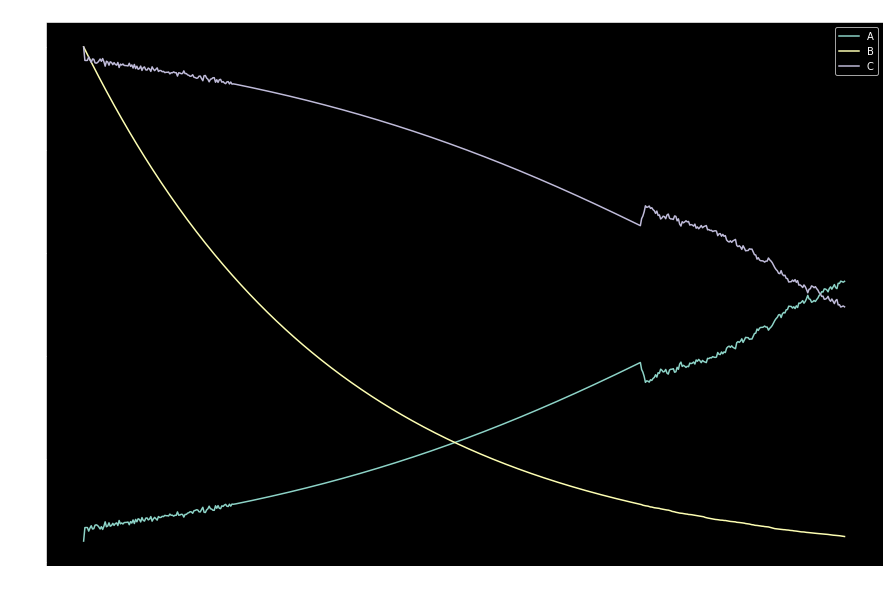

In [11]:
plt.figure(figsize=(15, 10))
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='{0}'.format(species))
plt.title('Example Hybrid Switching Model')
plt.legend(loc='best')

NameError: name 'tau_hybrid_results' is not defined

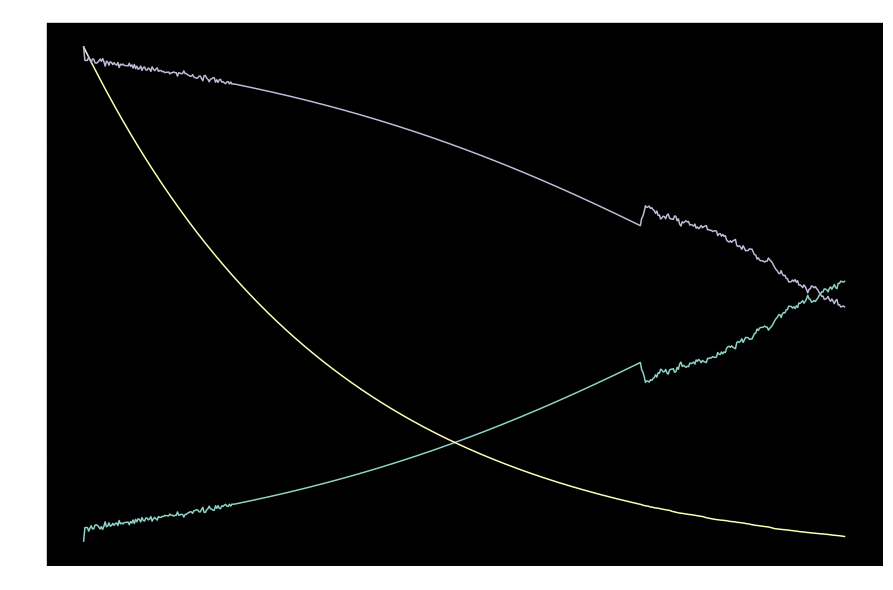

In [12]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results default vs higher tau + hybrid tolerance')
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='High tol-{0}'.format(species))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Default tol-{0}'.format(species))
    plt.legend(loc='best')

In [ ]:
%time results2 = model.run()

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results SSA vs higher tau + hybrid tolerance')
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='High tol-{0}'.format(species))
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='SSA-{0}'.format(species))
    plt.legend(loc='best')

In [ ]:
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [ ]:
results4 = model.run(solver=BasicODESolver)

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results SSA vs higher tau + hybrid tolerance')
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='High tol-{0}'.format(species))
for species in results4[0]:
    if species == 'time': continue
    plt.plot(results4[0]['time'], results4[0][species], label='SSA-{0}'.format(species))
    plt.legend(loc='best')